In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import wesanderson
import cftime

In [22]:
def plot_annual_temperature_scenarios(year, datasets, colors_dictionary, param, vmin = None, vmax = None):

    # Считаем среднегодовые значения температуры для каждого слоя и каждого сценария
    data_celsius = {}

    for scenario, ds in datasets.items():
        if param == 'mean':
            ds = ds.sel(time=str(year)).tsl.mean(dim='time')
            data_celsius[scenario] = (ds.values.flatten() - 273.15)
        else:
            ds = ds.sel(time=str(year)).tsl.var(dim='time')
            data_celsius[scenario] = ds.values.flatten()
        
    df = pd.DataFrame(data_celsius)

    bar_width = 0.19
    offsets = np.linspace(-bar_width*df.shape[0]/2, bar_width*df.shape[0]/2, df.shape[0])

    # Построение горизонтальных столбцов для каждого слоя и сценария
    for i, scenario in enumerate(df.columns):
        y_pos = np.arange(df.shape[0]) + offsets[i]
        plt.barh(y_pos, df[scenario], height=0.2, label=scenario, color=colors_dictionary[scenario])
        for j, value in enumerate(df[scenario]):
            plt.text(value+0.01, y_pos[j], f'{value:.3f}', va='center', ha='left')
    
    # Устанавливаем ограничения для оси X
    plt.xlim(vmin,vmax)
    
    # Инвертируем ось Y, чтобы слой 7 был снизу
    plt.gca().invert_yaxis()
    
    # Добавляем легенду, заголовки и подписи осей
    plt.legend(title='Scenarios')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Soil Layer')
    plt.title(f'Comparison of annual {param} per Soil Layer in {year}')
    plt.tight_layout()
    plt.show()

def plot_scenario_differences(nd_path, hd_path, ld_path, md_path, month = None, daily = False):
    months = ['Jan',"Feb", "Mar", "Apr", "May", "Jun", "Jul","Aug", "Sep", "Oct", "Nov","Dec"]

    nd = xr.open_dataset(nd_path)
    hd = xr.open_dataset(hd_path)
    ld = xr.open_dataset(ld_path)
    md = xr.open_dataset(md_path)

    # посчитать разницу
    diff_hd = hd['tsl'] - nd['tsl']  
    diff_ld = ld['tsl'] - nd['tsl']  
    diff_md = md['tsl'] - nd['tsl']  
    diff_nd = nd['tsl'] - nd['tsl']

    layers = nd['layer'].values

    fig, axes = plt.subplots(7, figsize=(10, 20))

    # разница по месяцам 
    for idx, layer in enumerate(layers):
        # Групприруем по месяцам
        if not daily:
            monthly_diff_hd = diff_hd.sel(layer=layer).groupby("time.month").mean(dim=['lat', 'lon'])
            monthly_diff_ld = diff_ld.sel(layer=layer).groupby("time.month").mean(dim=['lat', 'lon'])
            monthly_diff_md = diff_md.sel(layer=layer).groupby("time.month").mean(dim=['lat', 'lon'])
            monthly_diff_nd = diff_nd.sel(layer=layer).groupby("time.month").mean(dim=['lat', 'lon'])

            ax = axes[idx]

            ax.plot(months, monthly_diff_nd.groupby("time.month").mean(), label=f'ND', linestyle='-', marker='o')
            ax.plot(months, monthly_diff_hd.groupby("time.month").mean(), label=f'HD - ND', linestyle='-', marker='o')
            ax.plot(months, monthly_diff_ld.groupby("time.month").mean(), label=f'LD - ND', linestyle='-', marker='o')
            ax.plot(months, monthly_diff_md.groupby("time.month").mean(), label=f'MD - ND', linestyle='-', marker='o')

            # ax.set_xlabel("Месяц")
            ax.set_ylabel("Разница")
            ax.set_title(f"Горизонт {layer}")
        else:
            daily_diff_hd = diff_hd.sel(layer=layer, time = diff_hd.time.dt.month == month).mean(dim=['lat', 'lon'])
            daily_diff_ld = diff_ld.sel(layer=layer, time = diff_hd.time.dt.month == month).mean(dim=['lat', 'lon'])
            daily_diff_md = diff_md.sel(layer=layer, time = diff_hd.time.dt.month == month).mean(dim=['lat', 'lon'])
            daily_diff_nd = diff_nd.sel(layer=layer, time = diff_hd.time.dt.month == month).mean(dim=['lat', 'lon'])

            ax = axes[idx]
            days = daily_diff_hd.groupby("time.day").mean().day

            ax.plot(days, daily_diff_nd.groupby("time.day").mean(), label=f'ND', linestyle='-', marker='o')
            ax.plot(days, daily_diff_hd.groupby("time.day").mean(), label=f'HD - ND', linestyle='-', marker='o')
            ax.plot(days, daily_diff_ld.groupby("time.day").mean(), label=f'LD - ND', linestyle='-', marker='o')
            ax.plot(days, daily_diff_md.groupby("time.day").mean(), label=f'MD - ND', linestyle='-', marker='o')
           
            ax.set_xlabel("День")
            ax.set_ylabel("Разница")
            ax.set_title(f"Горизонт: {layer}. Месяц: {month}")

        ax.legend(ncols = 2)
        ax.grid()
        
    plt.tight_layout()
    plt.show()

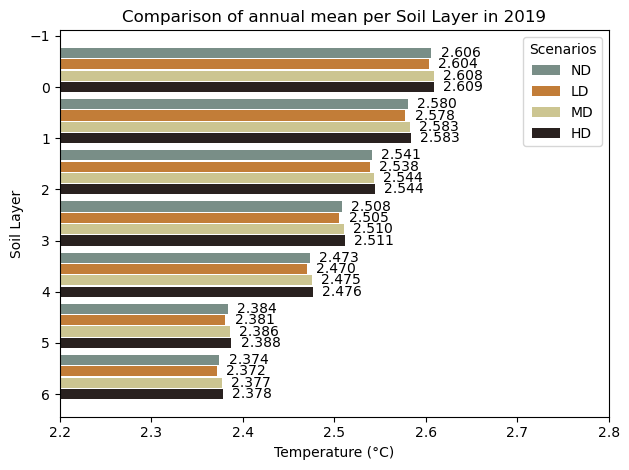

In [57]:
folder = 'experiment_1_dai/halfhourly'
dirs = [f for f in os.listdir(folder)]
colors = wesanderson.film_palette('Moonrise Kingdom', 1)

datasets = [xr.open_dataset(folder + "/" + d) for d in dirs]
data_dict = {
    "ND": xr.open_dataset(folder + "/" + "tsl_halfhourly_ND.nc"),
    "LD": xr.open_dataset(folder + "/" + "tsl_halfhourly_LD.nc"),
    'MD': xr.open_dataset(folder + "/" + "tsl_halfhourly_MD.nc"),
    'HD': xr.open_dataset(folder + "/" + "tsl_halfhourly_HD.nc"),
}
colors_dict = {
    "ND": colors[0],
    "LD": colors[1],
    'MD': colors[2],
    'HD': colors[3],
}

plot_annual_temperature_scenarios(2019, data_dict, colors_dict,'mean', 2.2,2.8)

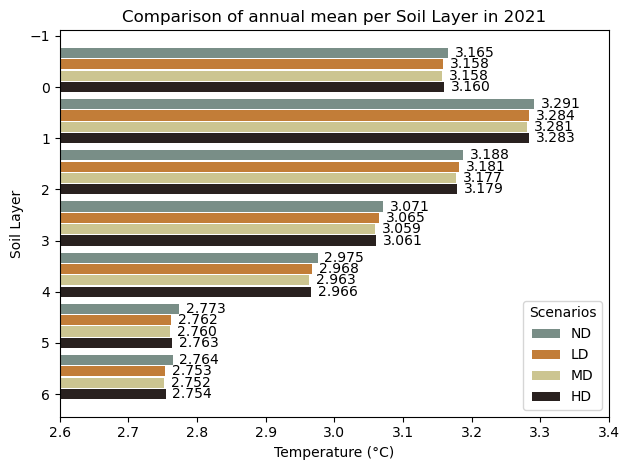

In [58]:
plot_annual_temperature_scenarios(2021, data_dict, colors_dict,'mean',2.6,3.4)

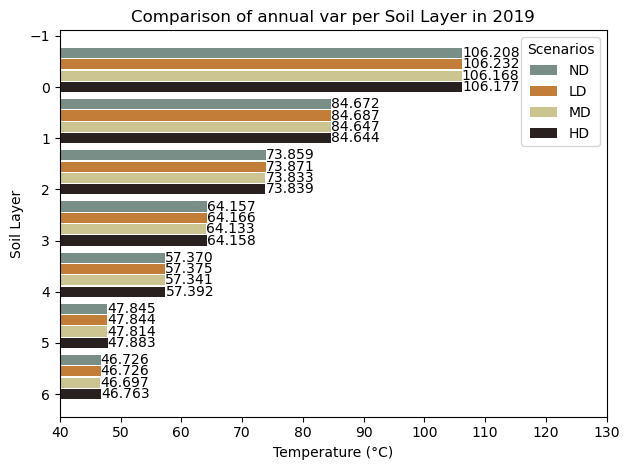

In [62]:
plot_annual_temperature_scenarios(2019, data_dict, colors_dict,'var', 40, 130)

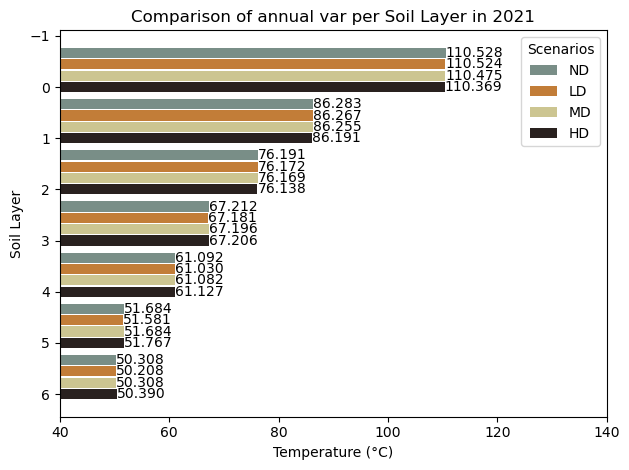

In [64]:
plot_annual_temperature_scenarios(2021, data_dict, colors_dict,'var', 40, 140)

Дни наибольших отличий от ND

In [4]:
working_folder = 'experiment_8_grass_albedo'

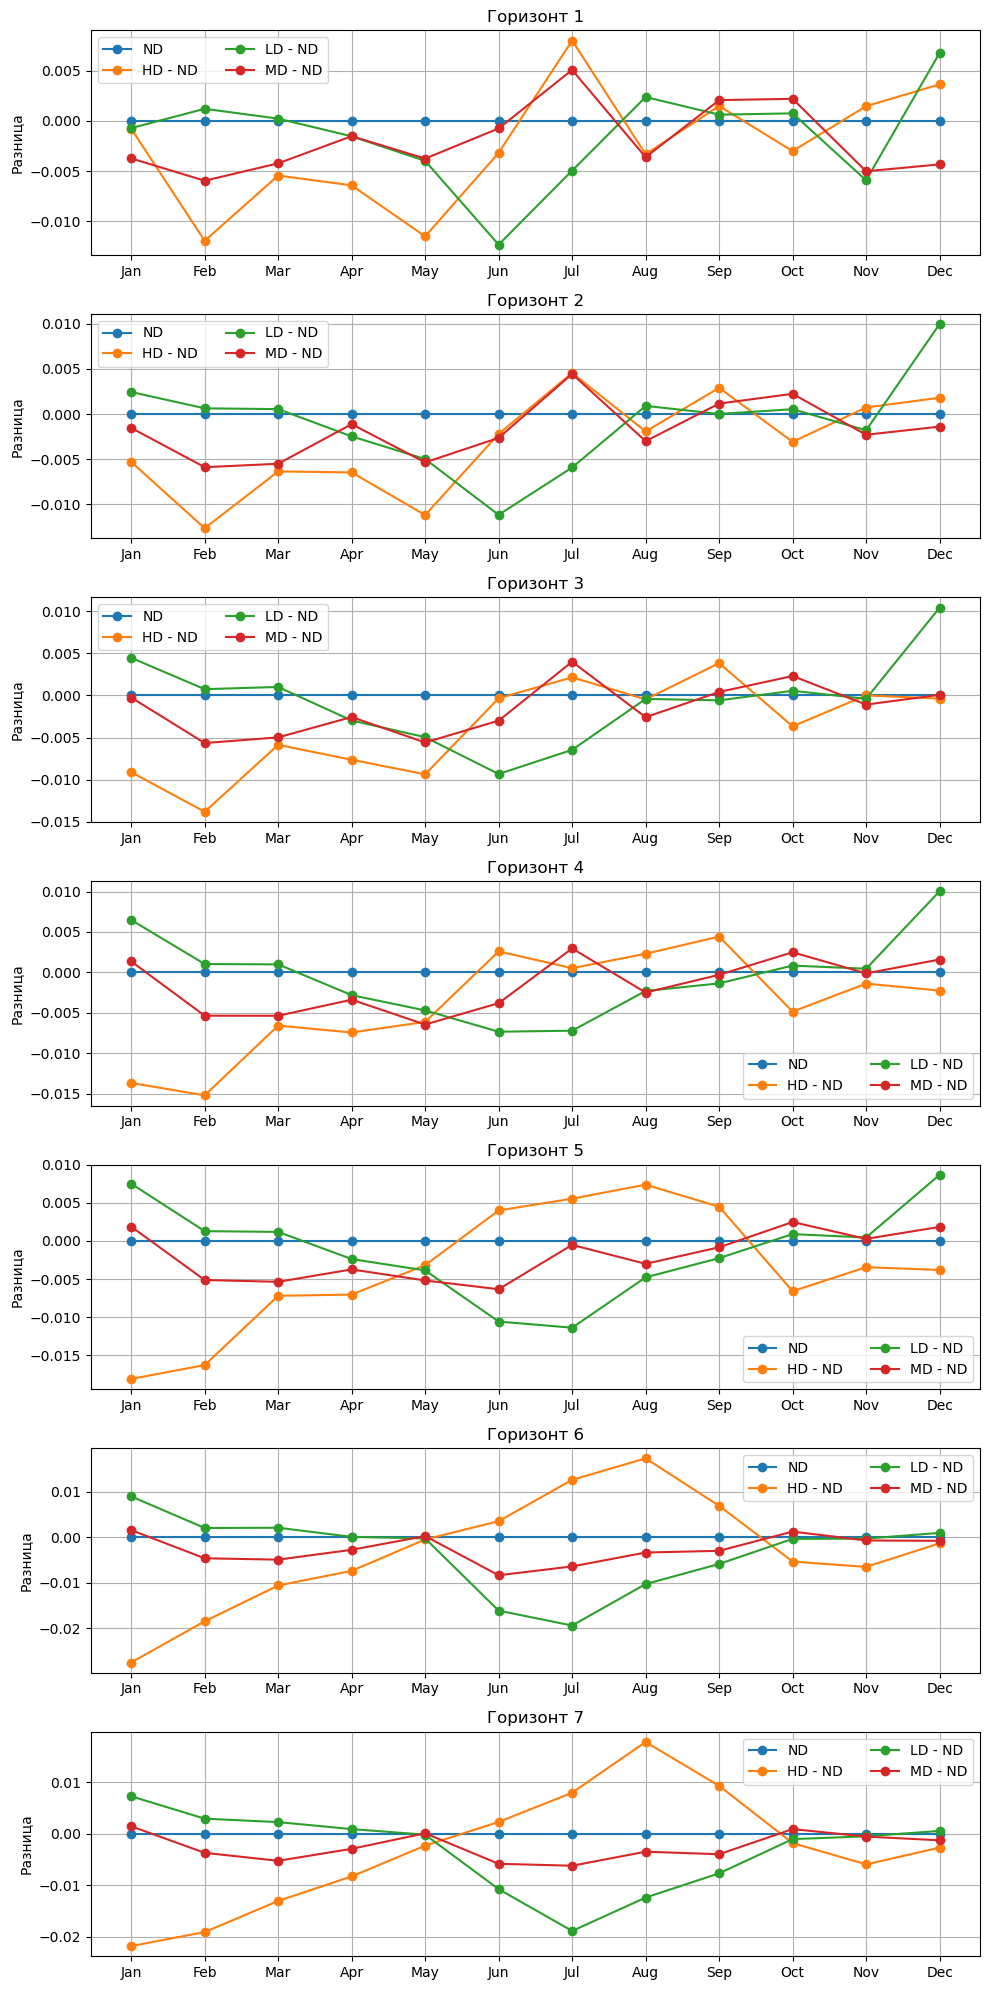

In [15]:
plot_scenario_differences(working_folder + "/monthly/tsl_monthly_ND.nc",
                          working_folder + "/monthly/tsl_monthly_HD.nc",
                          working_folder + "/monthly/tsl_monthly_LD.nc",
                          working_folder + "/monthly/tsl_monthly_MD.nc")

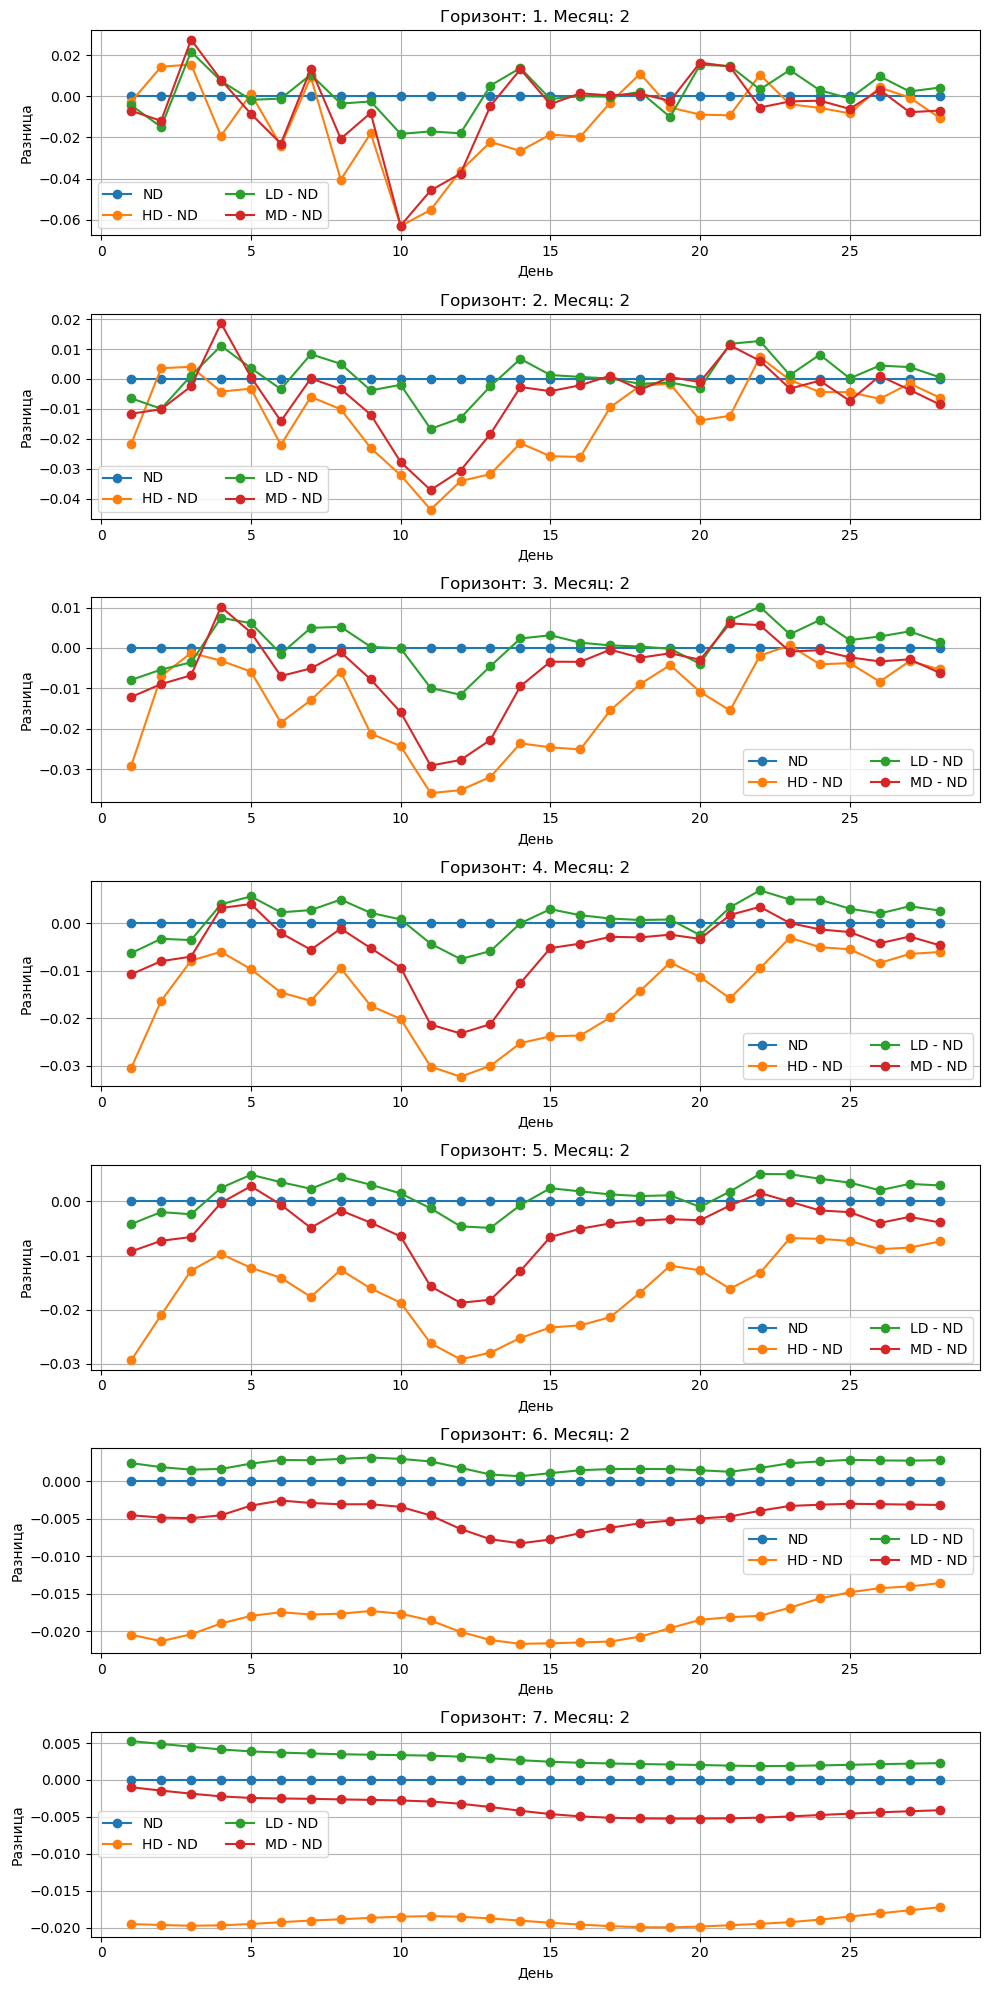

In [24]:
plot_scenario_differences(working_folder+"/daily/tsl_daily_ND.nc",
                          working_folder+"/daily/tsl_daily_HD.nc",
                          working_folder+"/daily/tsl_daily_LD.nc",
                          working_folder+"/daily/tsl_daily_MD.nc", month = 2, daily = True)